# Classical geostatistics (geosclassic wrapper) - examples 2D with non-stationary covariance model

Examples of estimation and simulation for a continuous variable in a 2D grid, based on simple and ordinary kriging, and with a non-stationary covariance model are proposed.

**Remark:** for details explanations about estimation and simulation, see jupyter notebook `ex_geosclassic_2d.ipynb`.

## Import what is required

In [1]:
import numpy as np
import math 
import matplotlib.pyplot as plt

# import from package 'geone'
import geone.covModel as gcm
import geone.geosclassicinterface as gci
import geone.img as img
import geone.imgplot as imgplt
# import geone.customcolors as ccol

### Remark
The matplotlib figures can be visualized in *interactive* mode:
- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Launching simulation and estimation in 2D
The following functions are used:
- `gci.simulate2D` for simulation 2D (sequential Gaussian simulation, SGS),
- `gci.estimate2D` for estimation 2D (kriging estimates and standard deviation).

See jupyter notebook `ex_geosclassic_2d.ipynb` for details.

## Simulation grid
The grid should be defined before defining the non-stationary covariance model.

In [2]:
nx, ny = 220, 230  # number of cells
dx, dy = 1.0, 1.0  # cell unit
ox, oy = 0.0, 0.0  # origin

dimension = (nx, ny)
spacing = (dx, dy)
origin = (ox, oy)

## Define a non-stationary covariance model in 2D: class `covModel2D`

A covariance model is defined by its elementary contributions given as a list of 2-tuples, 
whose the first component is the type given by a string (`nugget`, `spherical`, `exponential`, `gaussian`, ...) and the second component is a dictionary used to pass the required parameters (the weight (`w`), the range (`r`), ...).

An azimuth angle, `alpha`, can be specified in degrees: the coordinates system Ox'y' supporting the axes of the model (ranges) is obtained from the original coordinates system Oxy by applying a rotation of `-alpha` (i.e. clockwise for positive angle).

The parameters of each elementary contribution and the angle `alpha` can be set to a `numpy array` with values attached to the simulation grid. Hence, the size of the array and the number of grid cells must match (the array is reshaped if needed). In this way a non-stationary covariance model can be defined.

**Remark:** some functionalities such as getting the sill, range, or plotting the model are not available for non-stationary covariance model.

### Example: "from spherical to gaussian" model with orientation map

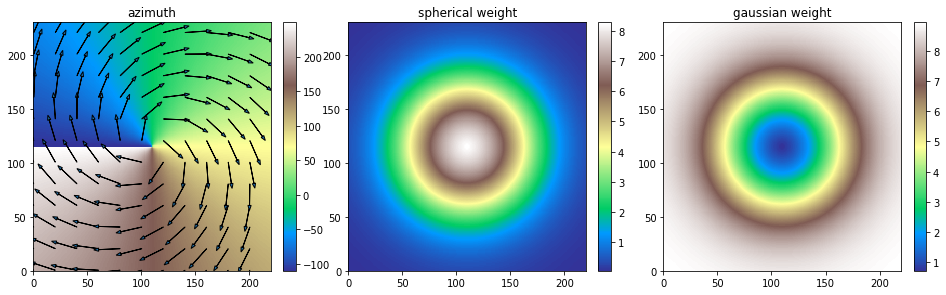

In [3]:
x_center = ox + 0.5*nx*dx
y_center = oy + 0.5*ny*dy 

xgrid = ox + (np.arange(nx)+0.5)*dx # x coordinate along the x-axis of the sim. grid
ygrid = oy + (np.arange(ny)+0.5)*dy # y coordinate along the y-axis of the sim. grid

xx, yy = np.meshgrid(xgrid, ygrid) # x, y coordinates of every sim. grid cell

# Define azimuth angle over the simulation grid
t = 180./np.pi
alpha = np.array(
    [90 - math.atan2(yi-y_center, xi-x_center)*t - 20
     for xi, yi in zip(xx.reshape(-1), yy.reshape(-1))]).reshape(xx.shape)

# Define weight for gaussian model over the simulation grid
gau_w = 9. * 1. / (1. + np.exp(-(np.sqrt((xx-x_center)**2+(yy-y_center)**2)-50)/20))
sph_w = 9 - gau_w

im_alpha = img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=1, val=alpha)
im_sph_w = img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=1, val=sph_w)
im_gau_w = img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=1, val=gau_w)

# Plot
plt.subplots(1,3, figsize=(16,12))

plt.subplot(1,3,1)
imgplt.drawImage2D(im_alpha, cmap='terrain', title="azimuth")
len_arrow = 20.
for i in range(0, nx, 20):
    for j in range(0, ny, 20):
        u = xx[j, i]
        v = yy[j, i]
        a = -alpha[j,i]/t
        plt.arrow(u, v, len_arrow*np.cos(a), len_arrow*np.sin(a), head_width=3)

plt.subplot(1,3,2)
imgplt.drawImage2D(im_sph_w, cmap='terrain', title="spherical weight")

plt.subplot(1,3,3)
imgplt.drawImage2D(im_gau_w, cmap='terrain', title="gaussian weight")

plt.show()

In [4]:
# Define the non-stationary covariance model 
cov_model = gcm.CovModel2D(elem=[
    ('spherical', {'w':sph_w, 'r':[120, 30]}), # elementary contribution
    ('gaussian', {'w':gau_w, 'r':[120, 30]}), # elementary contribution
    ], alpha=alpha, name='model-2D example')

### Conditional simulations (hard data) (function `gci.simulate2D`)
Define hard data. Note that the conditioning values will be attached to the grid cells containing the corresponding conditioning locations.

In [5]:
x = np.array([[ 10.,  20.], # 1st point
              [ 50.,  40.], # 2nd point
              [ 20., 150.], # 3rd point
              [125., 125.], # 4th point
              [200., 210.]]) # 5th point
v = [ -3., 2., 5., -2, -1.] # values

In [6]:
# Simulation
nreal = 200
np.random.seed(321)
geosclassic_output = gci.simulate2D(cov_model, dimension, spacing, origin, 
                                    x=x, v=v, method='simple_kriging', nreal=nreal)

Geos-Classic running... [VERSION 1.0 / BUILD NUMBER 20210714 / OpenMP 7 thread(s)]
Geos-Classic run complete

Warnings encountered (152 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)
#  2: WARNING 02015: solving kriging system fails (do as if no neighbor)


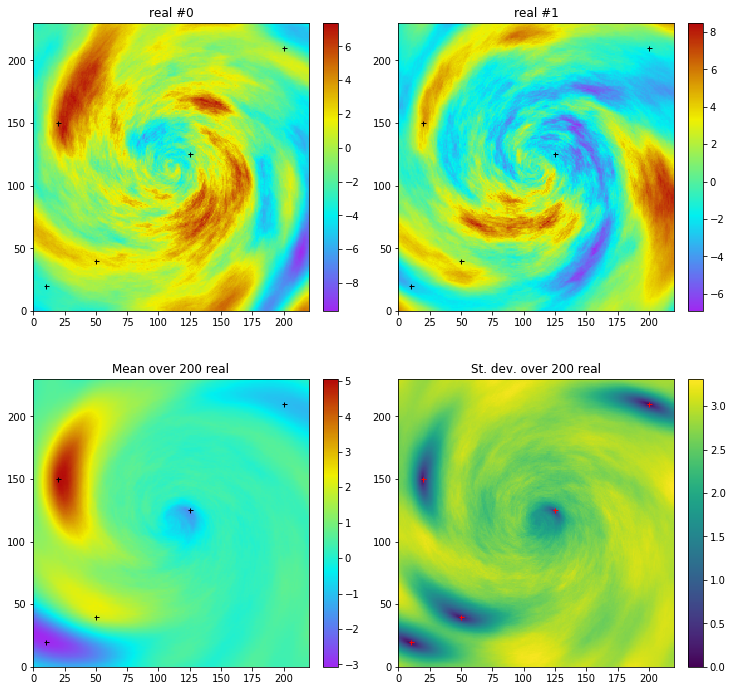

In [7]:
# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = img.imageContStat(simul, op='mean')
simul_std = img.imageContStat(simul, op='std')
fig, ax = plt.subplots(2, 2, figsize=(12,12))

# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 2, i+1)
    imgplt.drawImage2D(simul, iv=i)
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
    plt.title('real #{}'.format(i))

# mean of all real
plt.subplot(2, 2, 3)
imgplt.drawImage2D(simul_mean)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Mean over {} real'.format(nreal))

# standard deviation of all real
plt.subplot(2, 2, 4)
imgplt.drawImage2D(simul_std, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=5) # add conditioning point locations
plt.title('St. dev. over {} real'.format(nreal))

plt.show()

### Estimation: kriging estimates and standard deviation (function `gci.estimate2D`)
*Note:* unique search neighorhood can not be used with a non-stationary covariance model.

Extract random points from the first realization to set conditioning data.

In [8]:
im = img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=1, val=simul.val[0])
ps = img.extractRandomPointFromImage(im, 140, seed=444)
new_x = ps.val[0:2].T # location of conditioning data
new_v = ps.val[3]     # value at conditioning data

In [9]:
# Increase searchRadiusRelative to avoid "discontinuities"
geosclassic_output = gci.estimate2D(cov_model, dimension, spacing, origin, 
                                    x=new_x, v=new_v, method='simple_kriging',
                                    searchRadiusRelative=2.)

Geos-Classic running... [VERSION 1.0 / BUILD NUMBER 20210714 / OpenMP 7 thread(s)]
Geos-Classic run complete


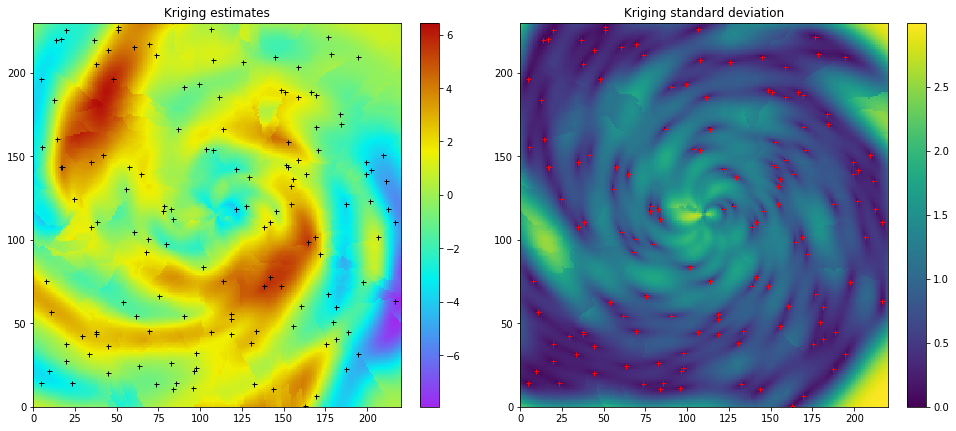

In [10]:
# Retrieve the results of estimation
estim = geosclassic_output['image']

plt.subplots(1, 2, figsize=(16,8))

# kriging estimates
plt.subplot(1, 2, 1)
imgplt.drawImage2D(estim, iv=0)
plt.plot(new_x[:,0],new_x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Kriging estimates')

# kriging standard deviation
plt.subplot(1, 2, 2)
imgplt.drawImage2D(estim, iv=1, cmap='viridis')
plt.plot(new_x[:,0],new_x[:,1], '+', c='red', markersize=5) # add conditioning point locations
plt.title('Kriging standard deviation')

plt.show()

## Conditioning with inequality data (simulation only)

Simulation can be done with usual hard data and inequality data consisting in a lower and/or upper bound at some points.

The conditioning locations with inequality data are first simulated (with truncated gaussian distribution) sequentially. Then, these locations are re-simulated following a new path as many times as desired (Gibbs sampler). The total number of path(s) is given by the keyword argument `nGibbsSamplerPath` (default: 50).

Define hard data and inequality data with minimal value and inequality with maximal value. Note that the conditioning values (hard, min. or max.) will be attached to the grid cells containing the corresponding conditioning locations.

In [11]:
# Hard data
x = np.array([[ 10.,  20.], # 1st point
              [ 50.,  40.], # 2nd point
              [ 20., 150.], # 3rd point
              [125., 125.], # 4th point
              [200., 210.]]) # 5th point
v = [ -3., 2., 5., -2, -1.] # values

# Inequality data
xIneqMin = np.array([[ 125., 100.],  # 1st point
                     [ 175.,  60.]]) # 2nd point
vIneqMin = [4., -2.2]  # lower bounds

xIneqMax = np.array([[  75., 175.],  # 1st point
                     [ 175.,  60.]]) # 2nd point
vIneqMax = [-4.1, -2.]  # upper bounds
# Note: second inequality data point has a lower bound and an upper bound

In [12]:
# Simulation
nreal = 200
np.random.seed(321)
geosclassic_output = gci.simulate2D(cov_model, dimension, spacing, origin, 
                                    x=x, v=v, 
                                    xIneqMin=xIneqMin, vIneqMin=vIneqMin,
                                    xIneqMax=xIneqMax, vIneqMax=vIneqMax,
                                    searchRadiusRelative=1.,
                                    method='simple_kriging', nreal=nreal)

Geos-Classic running... [VERSION 1.0 / BUILD NUMBER 20210714 / OpenMP 7 thread(s)]
Geos-Classic run complete

Warnings encountered (4 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)


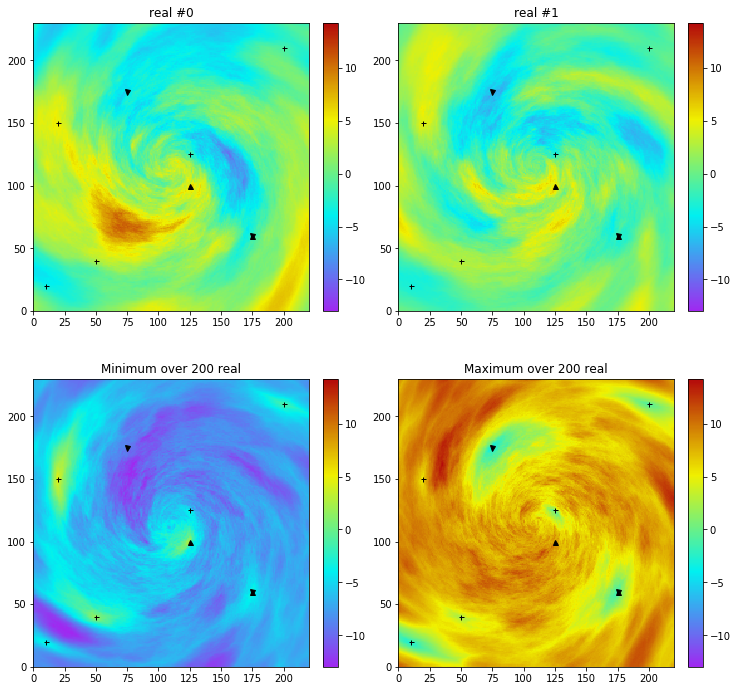

In [13]:
# Retrieve the realizations
simul = geosclassic_output['image']

# Compute min and max (pixel-wise)
simul_min = img.imageContStat(simul, op='min')
simul_max = img.imageContStat(simul, op='max')

# Plot the realizations and the results of estimation
vmin = np.min(simul.val)
vmax = np.max(simul.val)

plt.subplots(2, 2, figsize=(12,12))
# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 2, i+1)
    imgplt.drawImage2D(simul, iv=i, vmin=vmin, vmax=vmax)
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add hard data locations
    plt.plot(xIneqMin[:,0],xIneqMin[:,1], '^', c='black', markersize=5) # add inequality (min) data locations
    plt.plot(xIneqMax[:,0],xIneqMax[:,1], 'v', c='black', markersize=5) # add inequality (max) data locations
    plt.title('real #{}'.format(i))

# min
plt.subplot(2, 2, 3)
imgplt.drawImage2D(simul_min, iv=0, vmin=vmin, vmax=vmax)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.plot(xIneqMin[:,0],xIneqMin[:,1], '^', c='black', markersize=5) # add inequality (min) data locations
plt.plot(xIneqMax[:,0],xIneqMax[:,1], 'v', c='black', markersize=5) # add inequality (max) data locations
plt.title('Minimum over {} real'.format(nreal))

# max
plt.subplot(2, 2, 4)
imgplt.drawImage2D(simul_max, iv=0, vmin=vmin, vmax=vmax)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.plot(xIneqMin[:,0],xIneqMin[:,1], '^', c='black', markersize=5) # add inequality (min) data locations
plt.plot(xIneqMax[:,0],xIneqMax[:,1], 'v', c='black', markersize=5) # add inequality (max) data locations
plt.title('Maximum over {} real'.format(nreal))

plt.show()

### Check that conditioning data are honoured

In [14]:
# Get index of conditioning location in simulation grid
hd_grid_index = [img.pointToGridIndex(xx[0], xx[1], 0, dx, dy, 1., ox, oy, 0.) for xx in x]
ineqMin_grid_index = [img.pointToGridIndex(xx[0], xx[1], 0, dx, dy, 1., ox, oy, 0.) for xx in xIneqMin]
ineqMax_grid_index = [img.pointToGridIndex(xx[0], xx[1], 0, dx, dy, 1., ox, oy, 0.) for xx in xIneqMax]

# Min and max value at hard data
min_value_at_hd = [simul_min.val[0][grid_index[::-1]] for grid_index in hd_grid_index]
max_value_at_hd = [simul_max.val[0][grid_index[::-1]] for grid_index in hd_grid_index]
print('Hard data value:\n{}'.format(v))
print('Min and max value at hard data:\n{}\n{}\n'.format(
    min_value_at_hd, max_value_at_hd))

# Min and max value at inequality data with minimal value
min_value_at_ineqMin = [simul_min.val[0][grid_index[::-1]] for grid_index in ineqMin_grid_index]
max_value_at_ineqMin = [simul_max.val[0][grid_index[::-1]] for grid_index in ineqMin_grid_index]
print('Minimal data value:\n{}'.format(vIneqMin))
print('Min and max value at inequality data with maximal value:\n{}\n{}\n'.format(
    min_value_at_ineqMin, max_value_at_ineqMin))

# Min and max value at inequality data with maximal value
min_value_at_ineqMax = [simul_min.val[0][grid_index[::-1]] for grid_index in ineqMax_grid_index]
max_value_at_ineqMax = [simul_max.val[0][grid_index[::-1]] for grid_index in ineqMax_grid_index]
print('Maximal data value:\n{}'.format(vIneqMax))
print('Min and max value at inequality data with maximal value:\n{}\n{}'.format(
    min_value_at_ineqMax, max_value_at_ineqMax))

Hard data value:
[-3.0, 2.0, 5.0, -2, -1.0]
Min and max value at hard data:
[-3.0, 2.0, 5.0, -2.0, -1.0]
[-3.0, 2.0, 5.0, -2.0, -1.0]

Minimal data value:
[4.0, -2.2]
Min and max value at inequality data with maximal value:
[4.002838372496012, -2.198507295656031]
[8.93297944080593, -2.0020216173237424]

Maximal data value:
[-4.1, -2.0]
Min and max value at inequality data with maximal value:
[-9.719181062002516, -2.198507295656031]
[-4.102851043235016, -2.0020216173237424]
